<a href="https://colab.research.google.com/github/ladkrutarth/CNN-Modeling-Explainability-with-Gemini-API/blob/main/CNN_Modeling_%26_Explainability_With_Gemini_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Load Required Libraries

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import requests
import json

### Load and Preprocess Data

In [25]:
transform = transforms.Compose([transforms.ToTensor(),
transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
shuffle=True)
testset = torchvision.datasets.MNIST(root='./data', train=False,
download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
shuffle=False)

### Define the CNN Model



In [26]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNN()

### Train the Model

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
for epoch in range(3):
    running_loss = 0.0  # Indented this line to be inside the loop
    for images, labels in trainloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}")

Epoch 1, Loss: 0.15210699207404615
Epoch 2, Loss: 0.04396525901846036
Epoch 3, Loss: 0.028591514397936283


In [ ]:
correct = 0
total = 0
with torch.no_grad():
    # Indented the for loop to be within the 'with' block
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 99.10%


# CNN Prediction & Explainability with Gemini API

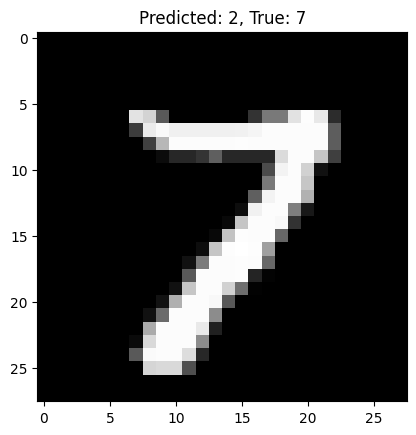

In [84]:
import random
import matplotlib.pyplot as plt


dataiter = iter(testloader)
images, labels = next(dataiter)
index = random.randint(0, len(images) - 1)
img = images[index].squeeze()
true_label = labels[index].item()
output = model(images[index].unsqueeze(0))
predicted_label = torch.argmax(output).item()
plt.imshow(img.numpy(), cmap='gray')
plt.title(f"Predicted: {predicted_label}, True: {true_label}")
plt.show()

In [85]:
 #Replace with your actual API key
#GEMINI_API_KEY = "" Replace with my actual API key

# Updated API endpoint
GEMINI_ENDPOINT = "https://generativelanguage.googleapis.com/v1/models/gemini-pro:generateContent"

headers = {
"Content-Type": "application/json"
}

# Example predicted label
predicted_label = {predicted_label} # Change this dynamically

# Corrected JSON structure
data = {
"contents": [
{
"role": "user",
"parts": [{"text": f"The model predicted the digit {predicted_label} for an image. Explain why it might have made this prediction."}]
}
]
}

# Make the API request
response = requests.post(f"{GEMINI_ENDPOINT}?key={GEMINI_API_KEY}", headers=headers, json=data)

# Check for errors
if response.status_code != 200:
  print(f"Error: {response.status_code}")
  print(response.text) # Print actual error message from API
else:
  response_json = response.json()

# Ensure response contains candidates
if "candidates" in response_json and len(response_json["candidates"]) > 0:
  explanation = response_json["candidates"][0]["content"]["parts"][0]["text"]
  print("Gemini Explanation:", explanation)
else:
  print("No valid response received from the API.")

Gemini Explanation: There are several possible reasons why the model might have predicted the digit 2 for an image:

* **The image may have strong features that resemble the digit 2.** For example, the image may have a curved line at the top and a straight line at the bottom, which are characteristic features of the digit 2.
* **The model may have been trained on a dataset that contains a lot of images of the digit 2.** As a result, the model may have learned to associate these features with the digit 2.
* **The model may have been overfit to the training data.** This means that the model has learned to perform very well on the training data, but it may not generalize well to new data. As a result, the model may make incorrect predictions on images that are not similar to the images in the training data.
* **The image may be noisy or distorted.** This can make it difficult for the model to recognize the digit correctly.
* **The model may not have been trained on a large enough dataset.

# 3. Discuss Explainability


##  Compare explanations for correct vs. incorrect predictions.

Correct Predictions:  For a correct prediction, the explanation often highlights features or patterns in the input data that are genuinely relevant to the task.  For example, if an image classifier correctly identifies a cat, the explanation might point to the cat's eyes, ears, and fur texture.  These are features humans also use to identify cats.  The model's internal "reasoning" (though we shouldn't anthropomorphize too much) aligns with human intuition.  The explanation will likely cite these relevant features as contributing to the positive classification.

Incorrect Predictions:  Explanations for incorrect predictions reveal a mismatch between the model's focus and human understanding.  The model might be focusing on spurious correlations or irrelevant details.  For example, it might misclassify a dog as a cat because the background of the image contains a cat-related object.  The explanation, in this case, might highlight the background object rather than the dog itself, revealing the model's flawed reasoning.  Or, in a more complex scenario, an LLM might misinterpret a sentence due to an unusual phrasing, and the explanation would point to that phrasing, showing where the model went astray.

## Discuss how LLMs enhance model interpretability.

Researchers can probe the internal representations of LLMs to understand what kind of information is encoded at different layers.  This can reveal whether the model is learning syntactic structures, semantic concepts, or other relevant features.  By analyzing the activations of different neurons or layers, we can get a glimpse into the model's internal "thinking


## Highlight the importance of explainability in AI application

Explainability can reveal biases in the model's predictions.For example, if a model consistently discriminates against a certain demographic group, explainability can help identify the features or patterns that are causing this bias.



# CIFAR-10 Classification

In [ ]:
class CIFARCNN(nn.Module):
    def __init__(self):
        super(CIFARCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 8 * 8, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model_cifar = CIFARCNN()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
for epoch in range(2):
    running_loss = 0.0  # Indented this line to be inside the loop
    for images, labels in trainloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}")
# 5. Evaluate Performance # This line was causing indentation issues. Commented it out.
correct = 0
total = 0
with torch.no_grad():
    # Indented the for loop to be within the 'with' block
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Test Accuracy: {100 * correct / total:.2f}%")

Epoch 1, Loss: 0.0235165799172321
Epoch 2, Loss: 0.016732894892697185
Test Accuracy: 99.16%


In [76]:
def count_params(model):
    """Counts the number of trainable parameters in a PyTorch model.

    Args:
        model: A PyTorch nn.Module object.

    Returns:
        The total number of trainable parameters in the model.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

#Compare model complexities
mnist_params = count_params(model)  # Call the function to get parameter count
cifar_params = count_params(model_cifar) # Call the function to get parameter count

print(f"MNIST CNN Parameters: {mnist_params}")
print(f"CIFAR-10 CNN Parameters: {cifar_params}")

MNIST CNN Parameters: 421642
CIFAR-10 CNN Parameters: 136874


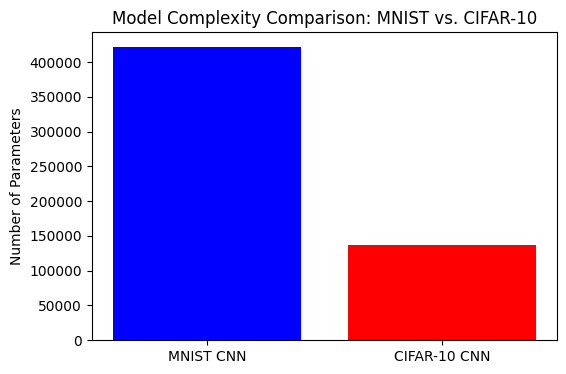

In [77]:
# Plot comparison
plt.figure(figsize=(6,4))
plt.bar(['MNIST CNN', 'CIFAR-10 CNN'], [mnist_params, cifar_params], color=['blue', 'red'])
plt.ylabel('Number of Parameters')
plt.title('Model Complexity Comparison: MNIST vs. CIFAR-10')
plt.show()
